### Imports

In [1]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers import LSTM

import gym
from gym.envs.registration import register

import pandas_datareader

### Settings

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
sns.set_style('whitegrid')

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [5]:
results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Helper functions

In [6]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

## Set up Gym Environment

Before using the custom environment, just like we used the Lunar Lander environment, we need to register it:

In [7]:
trading_days = 252

In [8]:
import gym_trader

In [9]:
env = gym.make('trader-v0')

INFO:gym_trader.envs.trader_env:gym_trader.envs.trader_env logger started.
INFO:gym_trader.envs.trader_env:loading data for AAPL...
INFO:gym_trader.envs.trader_env:got data for AAPL...
INFO:gym_trader.envs.trader_env:None


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 571 entries, 2015-12-16 to 2018-03-27
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  571 non-null    float64
 1   ret_2    571 non-null    float64
 2   ret_5    571 non-null    float64
 3   ret_10   571 non-null    float64
 4   ret_21   571 non-null    float64
 5   rsi      571 non-null    float64
 6   macd     571 non-null    float64
 7   atr      571 non-null    float64
 8   stoch    571 non-null    float64
 9   ultosc   571 non-null    float64
dtypes: float64(10)
memory usage: 49.1 KB


C:\Users\TJ\anaconda3\envs\ml01-02\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
env.data_source.data

,returns,ret_2,ret_5,ret_10,ret_21,rsi,macd,atr,stoch,ultosc
Date,,,,,,,,,,
2015-12-16,0.007693,-0.610350,-1.331473,-1.119232,-0.635002,-1.271469,-0.719635,0.323254,-0.399973,-0.964700
2015-12-17,-0.021196,-0.790899,-2.133395,-1.370505,-0.876156,-1.271469,-0.850969,0.409091,0.301589,-1.672155
2015-12-18,-0.027069,-2.530575,-2.174715,-2.576139,-1.669043,-1.271469,-1.005590,0.535431,0.405886,-1.921630
2015-12-21,0.012261,-0.866263,-1.614148,-2.212871,-1.674786,-1.001258,-1.154519,0.450313,0.202187,-1.512374
2015-12-22,-0.000932,0.486501,-1.089265,-2.222958,-1.744189,-0.493204,-1.291169,0.314996,-0.382473,-1.081699
...,...,...,...,...,...,...,...,...,...,...
2018-03-21,-0.022655,-1.267561,-1.433470,-0.660723,-0.323280,-1.527705,0.656609,1.717833,0.115097,-2.119341
2018-03-22,-0.014159,-1.957986,-1.907457,-1.190542,-0.463213,-1.527705,0.496698,1.805057,0.366142,-2.550883
2018-03-23,-0.023128,-1.981832,-2.506815,-2.016118,-0.919040,-1.527705,0.278725,1.984780,0.623780,-3.090652


### Initialize Trading Environment

We can instantiate the environment by using the desired trading costs and ticker:

In [11]:
trading_environment = gym.make('trader-v0')
trading_environment.trading_days = trading_days
trading_environment.trading_cost_bps = 1e-3
trading_environment.time_cost_bps = 1e-4
trading_environment.ticker = 'AAPL'
trading_environment.seed(42)

INFO:gym_trader.envs.trader_env:loading data for AAPL...
INFO:gym_trader.envs.trader_env:got data for AAPL...
INFO:gym_trader.envs.trader_env:None


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 571 entries, 2015-12-16 to 2018-03-27
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  571 non-null    float64
 1   ret_2    571 non-null    float64
 2   ret_5    571 non-null    float64
 3   ret_10   571 non-null    float64
 4   ret_21   571 non-null    float64
 5   rsi      571 non-null    float64
 6   macd     571 non-null    float64
 7   atr      571 non-null    float64
 8   stoch    571 non-null    float64
 9   ultosc   571 non-null    float64
dtypes: float64(10)
memory usage: 49.1 KB


C:\Users\TJ\anaconda3\envs\ml01-02\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[42]

### Get Environment Params

In [12]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = 1000
# max_episode_steps = trading_environment.spec.max_episode_steps

## Define Trading Agent

In [13]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = True

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model


  
    
    
    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        print(targets)
        q_values[[self.idx, actions]] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

## Define hyperparameters

In [14]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

### NN Architecture

In [15]:
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

### Experience Replay

In [16]:
replay_capacity = int(1e6)
batch_size = 4096

### $\epsilon$-greedy Policy

In [17]:
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

## Create DDQN Agent

We will use [TensorFlow](https://www.tensorflow.org/) to create our Double Deep Q-Network .

In [18]:
tf.keras.backend.clear_session()

In [19]:
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [20]:
ddqn.online_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 256)               2816      
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 3)                 771       
Total params: 69,379
Trainable params: 69,379
Non-trainable params: 0
_________________________________________________________________


## Run Experiment

### Set parameters

In [21]:
total_steps = 0
max_episodes = 300

### Initialize variables

In [22]:
episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

## Visualiztion

In [23]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, format_time(total), 
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon))

### Train Agent

In [25]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
    
        ddqn.memorize_transition(this_state, 
                                 action, 
                                 reward, 
                                 next_state, 
                                 0.0 if done else 1.0)
#         if ddqn.train:
#             ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    result = trading_environment.simulator.result()
    final = result.iloc[-1]

    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    market_nav = final.market_nav
    market_navs.append(market_nav)

    diff = nav - market_nav
    diffs.append(diff)
    if episode % 10 == 0:
        track_results(episode, np.mean(navs[-100:]), np.mean(navs[-10:]), 
                      np.mean(market_navs[-100:]), np.mean(market_navs[-10:]), 
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100), 
                      time() - start, ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

C:\Users\TJ\anaconda3\envs\ml01-02\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\TJ\anaconda3\envs\ml01-02\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  10 | 00:00:01 | Agent: -20.5% (-20.5%) | Market:  42.2% ( 42.2%) | Wins:  0.0% | eps:  0.960
  20 | 00:00:05 | Agent: -21.4% (-22.2%) | Market:  42.9% ( 43.6%) | Wins:  0.0% | eps:  0.921
  30 | 00:00:12 | Agent: -20.3% (-18.3%) | Market:  43.0% ( 43.2%) | Wins:  0.0% | eps:  0.881
  40 | 00:00:21 | Agent: -19.5% (-17.0%) | Market:  42.9% ( 42.8%) | Wins:  0.0% | eps:  0.842
  50 | 00:00:33 | Agent: -18.9% (-16.6%) | Market:  42.1% ( 38.9%) | Wins:  0.0% | eps:  0.802
  60 | 00:00:48 | Agent: -18.8% (-18.2%) | Market:  41.8% ( 40.0%) | Wins:  0.0% | eps:  0.762
  70 | 00:01:05 | Agent: -17.3% ( -8.2%) | Market:  41.4% ( 39.1%) | Wins:  0.0% | eps:  0.723
  80 | 00:01:24 | Agent: -16.8% (-13.4%) | Market:  41.5% ( 42.6%) | Wins:  0.0% | eps:  0.683
  90 | 00:01:46 | Agent: -16.9% (-18.1%) | Market:  42.3% ( 48.7%) | Wins:  0.0% | eps:  0.644
 100 | 00:02:10 | Agent: -16.8% (-15.3%) | Market:  42.7% ( 45.6%) | Wins:  0.0% | eps:  0.604
 110 | 00:02:37 | Agent: -16.5% (-17.6%) | Market:

In [26]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs,
                        'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 1 to 300
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              300 non-null    float64
 1   Market             300 non-null    float64
 2   Difference         300 non-null    float64
 3   Strategy Wins (%)  201 non-null    float64
dtypes: float64(4)
memory usage: 11.7 KB


In [31]:
results

,Agent,Market,Difference,Strategy Wins (%)
Episode,,,,
1,0.838894,1.637076,-0.798182,NaN
2,0.892999,1.336310,-0.443311,NaN
3,0.659735,1.485107,-0.825372,NaN
4,0.808344,1.336258,-0.527914,NaN
5,0.787542,1.544353,-0.756811,NaN
...,...,...,...,...
296,0.961045,1.267281,-0.306236,0.0
297,0.988964,1.262026,-0.273063,0.0
298,0.988964,1.270828,-0.281864,0.0


In [32]:
results.to_csv(results_path / 'results.csv', index=False)

C:\Users\TJ\anaconda3\envs\ml01-02\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


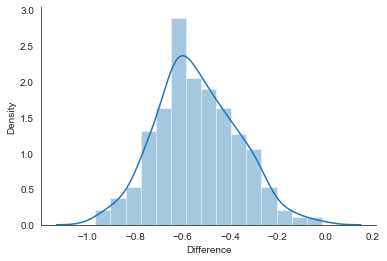

In [33]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

### Evaluate Results

In [34]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 1 to 300
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              300 non-null    float64
 1   Market             300 non-null    float64
 2   Difference         300 non-null    float64
 3   Strategy Wins (%)  201 non-null    float64
dtypes: float64(4)
memory usage: 11.7 KB


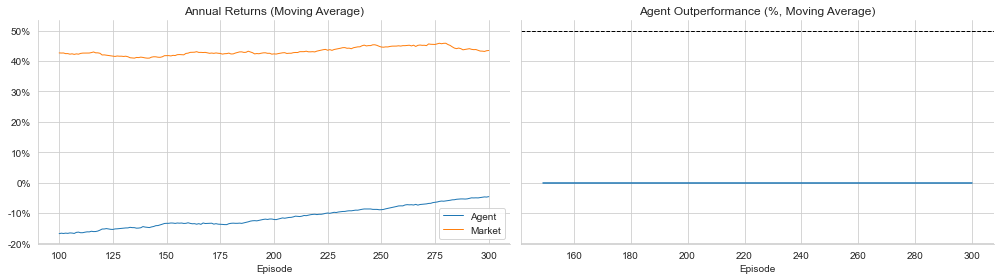

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(50).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'performance', dpi=300)